# Anomaly Detection Using machine Learning
This notebook aims to detect anomalies in the given dataset using various machine learning techniques.

## Introduction

##### In this project, we will identify anomalies using the dataset `anomaly_detection.csv`. Detecting anomalies is crucial for identifying unusual events that might indicate errors, fraud, or rare incidents. 

## Objective
- Perform data exploration and visualization.
- Preprocess and clean the data.
- Apply machine learning algorithms for anomaly detection.
- Evaluate model performance using appropriate metrics.

## Step 1: Importing Necessary Libraries
The required libraries for data manipulation, visualization, and model building are imported here.

In [46]:
# Importing Necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split,  RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score ,classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

In [47]:
import warnings
warnings.filterwarnings('ignore')

## Step 2: Data Loading and Inspection
The dataset is loaded into a Pandas DataFrame for inspection. Initial exploration includes viewing data types, checking for missing values, and understanding data distribution.

In [48]:
Data_file = "/Users/senakshikrishnamurthy/Desktop/Sena/Project/Anomly_detection/anomaly_detection.csv"
df = pd.read_csv(Data_file)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   date     5574 non-null   object
 1   value    5574 non-null   int64 
 2   agency   5574 non-null   object
 3   anomaly  5574 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 174.3+ KB


<Axes: xlabel='date', ylabel='value'>

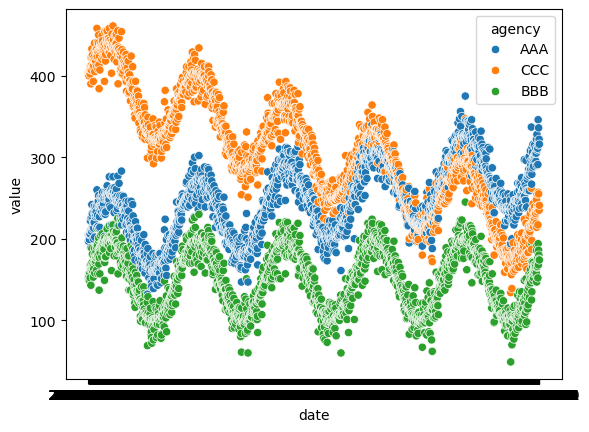

In [49]:
sns.scatterplot(data=df, x='date', y='value', hue='agency')

In [50]:
df.head()

,date,value,agency,anomaly
0,2020-01-01,197,AAA,0
1,2020-01-01,404,CCC,0
2,2020-01-01,153,BBB,0
3,2020-01-02,205,AAA,0
4,2020-01-02,401,CCC,0


In [51]:
df.describe()

,value,anomaly
count,5574.000000,5574.000000
mean,233.842662,0.453714
std,82.684253,0.497898
min,49.000000,0.000000
25%,174.250000,0.000000
50%,228.000000,0.000000
75%,291.000000,1.000000
max,461.000000,1.000000


- The "anomaly" column likely represents a binary flag (0 or 1), where 1 indicates an anomaly. The mean of 0.45 suggests that approximately 45% of the data points are flagged as anomalies.
- The median of the anomaly column is 0, but the 75% percentile is 1. This means that more than 50% of the data is 0, but a significant portion of the data is 1.
- The "value" column has a reasonable spread of values, as shown by the standard deviation.

<Axes: xlabel='date', ylabel='value'>

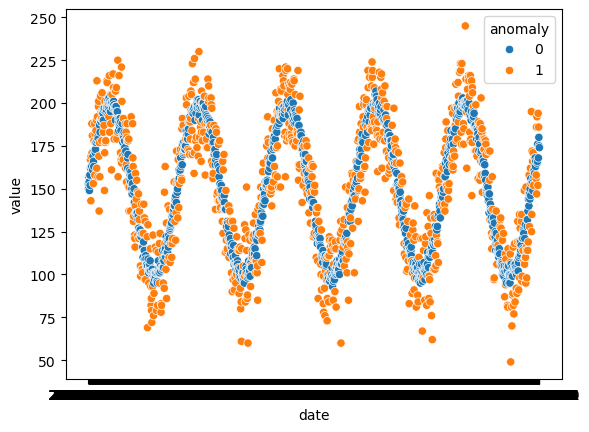

In [52]:
sns.scatterplot(data=df.query("agency=='BBB'"), x='date', y='value', hue='anomaly')

##  STEP 3 :Freature Engineering

- we have very less number of columns to dedect the anomaly. 
- So, we are creating other features:

In [53]:
#feature engineering
# 1 - date
df['date'] = pd.to_datetime(df['date'])

df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['dayofweek'] = df['date'].dt.dayofweek


#2 - Rolling window features and lag features
df = df.sort_values(by=['agency', 'date'])

df['value_rolling_mean_7'] = df.groupby('agency')['value'].transform(lambda x: x.rolling(7, min_periods=1).mean())
df['value_rolling_std_7'] = df.groupby('agency')['value'].transform(lambda x: x.rolling(7, min_periods=1).std())


df['value_lag_1'] = df.groupby('agency')['value'].shift(1)
df['value_lag_7'] = df.groupby('agency')['value'].shift(7)

#4 - trend features
df['value_trend'] = df.groupby('agency')['value'].transform(lambda x: x.diff(7))
df['trend'] = df['value'].diff()

# 5 - encoding agency
df = pd.get_dummies(df, columns=['agency'], prefix='agency')




In [54]:
print(df.info())
df

<class 'pandas.core.frame.DataFrame'>
Index: 5574 entries, 0 to 5573
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  5574 non-null   datetime64[ns]
 1   value                 5574 non-null   int64         
 2   anomaly               5574 non-null   int64         
 3   year                  5574 non-null   int32         
 4   month                 5574 non-null   int32         
 5   day                   5574 non-null   int32         
 6   dayofweek             5574 non-null   int32         
 7   value_rolling_mean_7  5574 non-null   float64       
 8   value_rolling_std_7   5571 non-null   float64       
 9   value_lag_1           5571 non-null   float64       
 10  value_lag_7           5553 non-null   float64       
 11  value_trend           5553 non-null   float64       
 12  trend                 5573 non-null   float64       
 13  agency_AAA            5

,date,value,anomaly,year,month,day,dayofweek,value_rolling_mean_7,value_rolling_std_7,value_lag_1,value_lag_7,value_trend,trend,agency_AAA,agency_BBB,agency_CCC
0,2020-01-01,197,0,2020,1,1,2,197.000000,NaN,NaN,NaN,NaN,NaN,True,False,False
3,2020-01-02,205,0,2020,1,2,3,201.000000,5.656854,197.0,NaN,NaN,8.0,True,False,False
6,2020-01-03,205,0,2020,1,3,4,202.333333,4.618802,205.0,NaN,NaN,0.0,True,False,False
9,2020-01-04,200,0,2020,1,4,5,201.750000,3.947573,205.0,NaN,NaN,-5.0,True,False,False
14,2020-01-05,199,0,2020,1,5,6,201.200000,3.633180,200.0,NaN,NaN,-1.0,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5561,2025-01-27,238,0,2025,1,27,0,239.428571,13.599720,257.0,214.0,24.0,-19.0,False,False,True
5563,2025-01-28,255,1,2025,1,28,1,239.428571,13.599720,238.0,255.0,0.0,17.0,False,False,True
5566,2025-01-29,238,0,2025,1,29,2,240.142857,13.334524,255.0,233.0,5.0,-17.0,False,False,True
5568,2025-01-30,235,0,2025,1,30,3,240.000000,13.391540,238.0,236.0,-1.0,-3.0,False,False,True


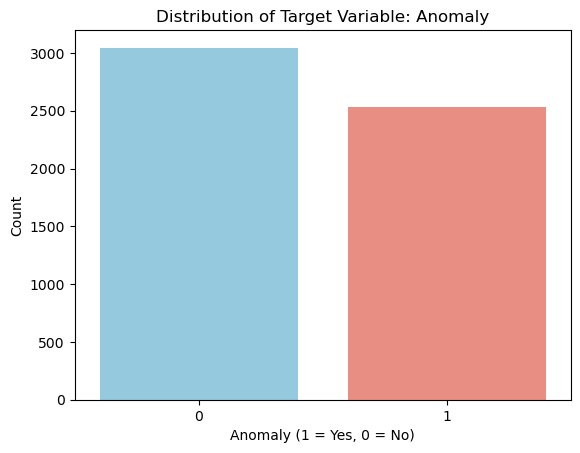

In [58]:
# Distribution of the target variable
sns.countplot(x='anomaly', data=df, palette=['skyblue', 'salmon'])
plt.title('Distribution of Target Variable: Anomaly')
plt.xlabel('Anomaly (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.show()

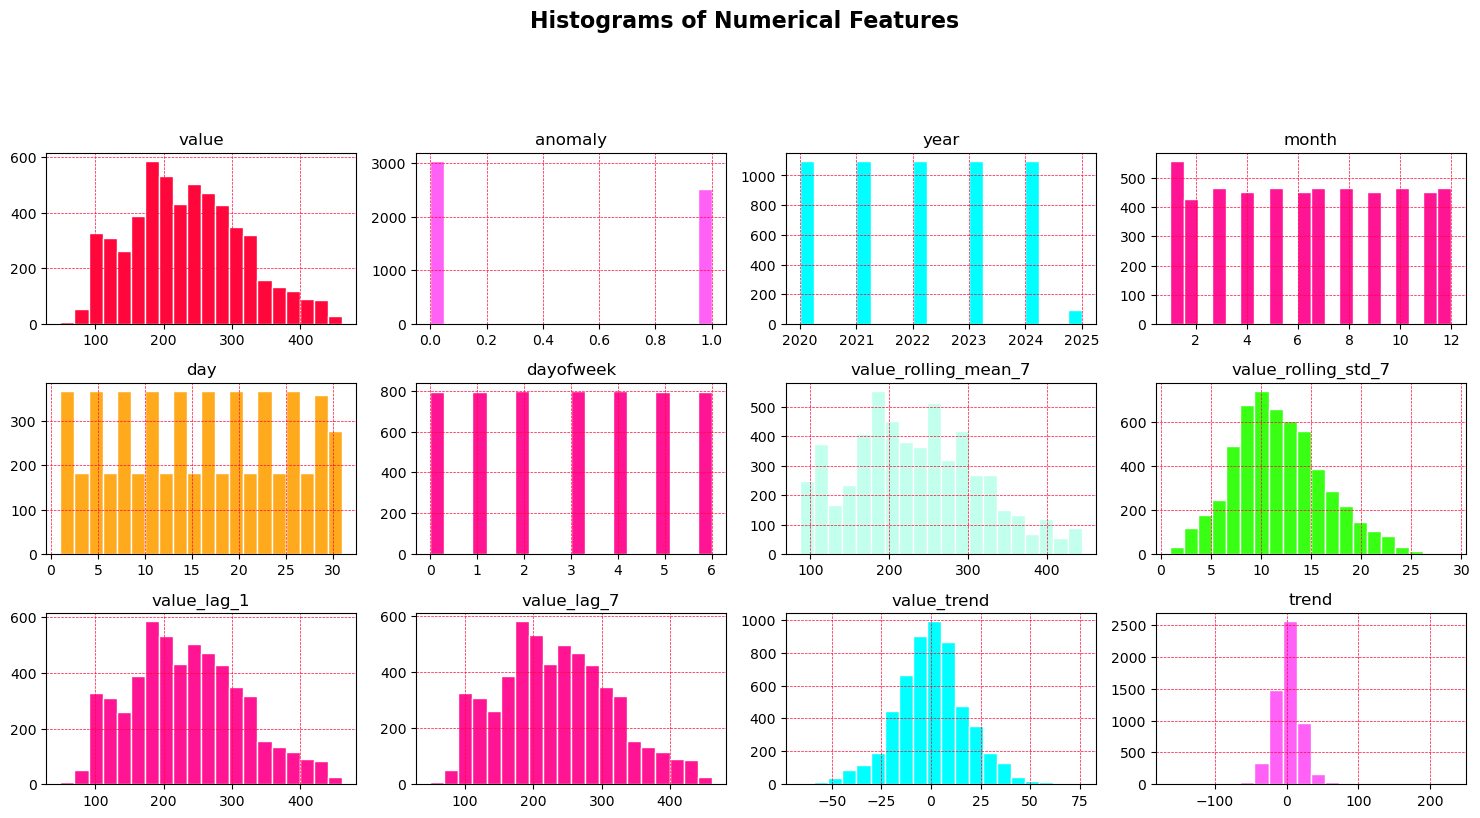

In [56]:
# Defining some neon colors
neon_colors = ['#39FF14', '#FF073A', '#00FFFF', '#FF61F6', '#FFAA1D', '#F8333C', '#C2FFED', '#FF1493']

# Selecting numerical columns from the dataset
numerical_columns = df.select_dtypes(include=['float64', 'int64', 'int32']).columns.tolist()

# Plot histograms with neon colors
plt.figure(figsize=(15, 10))
plt.suptitle('Histograms of Numerical Features', fontsize=16, color='Black', fontweight='bold', y=1.02)

for i, col in enumerate(numerical_columns):
    plt.subplot(len(numerical_columns) // 4 + 1, 4, i + 1)
    plt.hist(df[col].dropna(), bins=20, color=np.random.choice(neon_colors), edgecolor='white')
    plt.title(col, color='Black')
    plt.grid(color='#FF073A', linestyle='--', linewidth=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


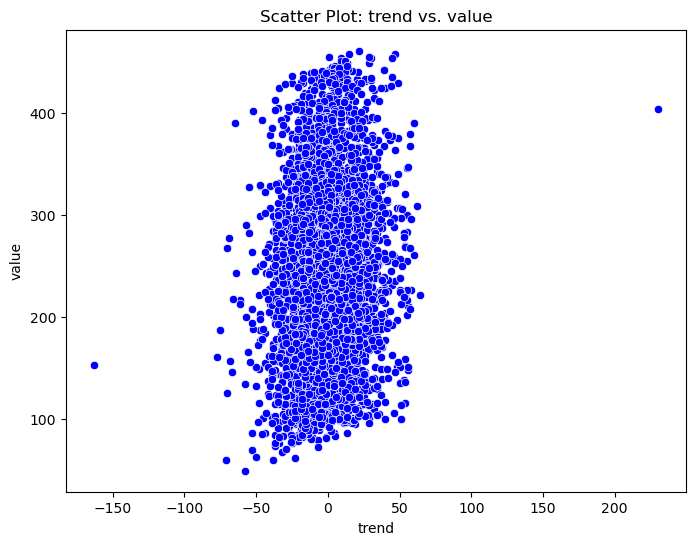

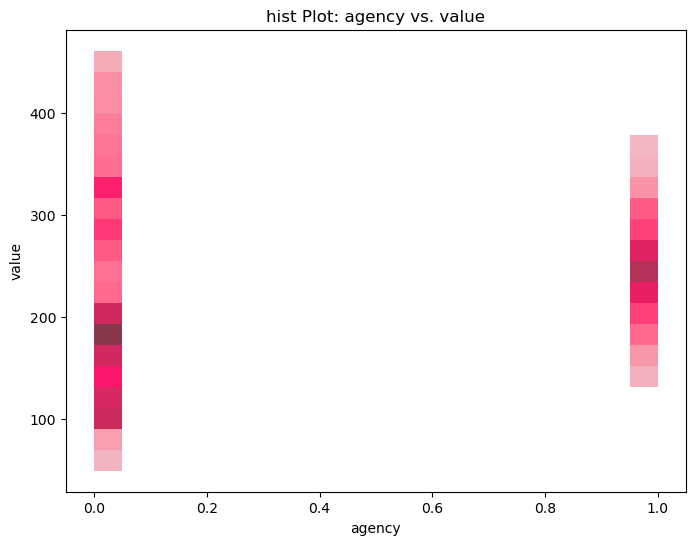

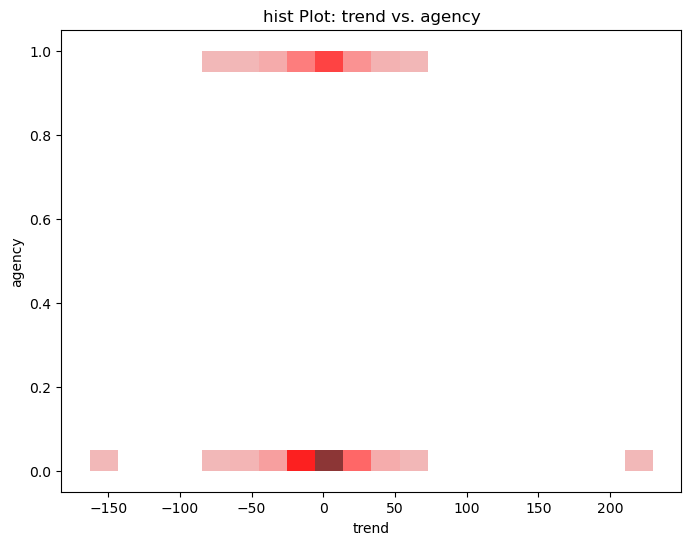

In [62]:
# Splitting the dataset into features and target variable
# 1. Scatter plot: trend vs. value
plt.figure(figsize=(8, 6))
sns.scatterplot(x='trend', y='value', data=df, color='blue')
plt.title('Scatter Plot: trend vs. value')
plt.xlabel('trend')
plt.ylabel('value')
plt.show()

# 2. hist plot: anomly vs. anomaly_rolling_mean
plt.figure(figsize=(8, 6))
sns.histplot(x='agency_AAA', y='value', data=df, color='pink', bins=20)
plt.title('hist Plot: agency vs. value')
plt.xlabel('agency')
plt.ylabel('value')
plt.show()

# 3. hist plot: trend vs. agency
plt.figure(figsize=(8, 6))
sns.histplot(x='trend', y='agency_AAA', data=df, color='red', bins=20)
plt.title('hist Plot: trend vs. agency')
plt.xlabel('trend')
plt.ylabel('agency')
plt.show()




## STEP 4: Spliting the Data into train and test data

- This code splits the dataset into training and testing sets using an 80/20 split.
- 1st the data is divied into anomaly and non-anomaly then splited by the ratio and combined.



In [63]:
# Sorting the DataFrame by date

df.sort_values(by='date', inplace=True)
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

def split_data_by_year(df, train_years):
    train_data = df[df['year'].isin(train_years)]
    test_data = df[~df['year'].isin(train_years)]

    return train_data, test_data

# Training on years 2020 to 2023, test on the rest
train_years = [2020, 2021, 2022, 2023]
train_data, test_data = split_data_by_year(df, train_years)

print(f"Training Data Size: {train_data.shape}")
print(f"Test Data Size: {test_data.shape}")


Training Data Size: (4383, 16)
Test Data Size: (1191, 16)


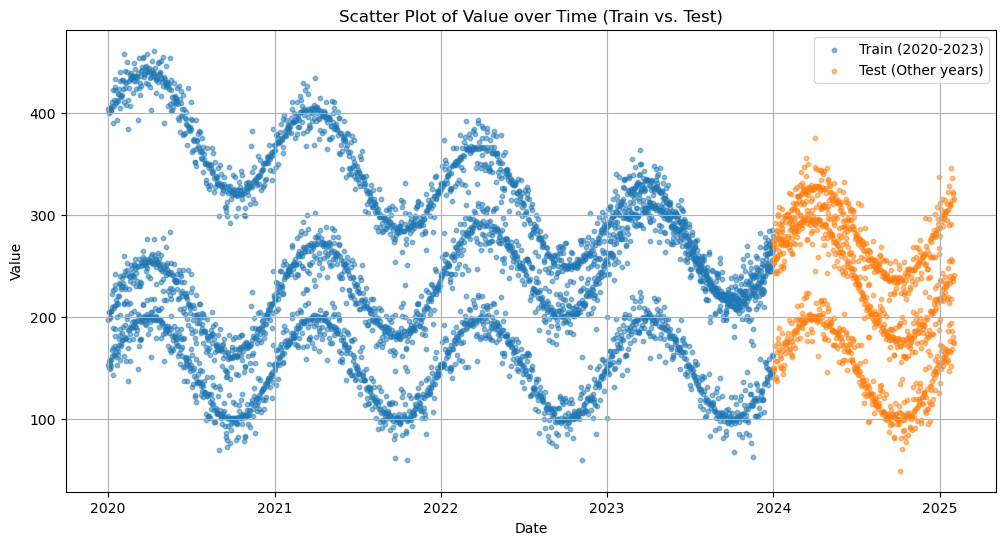

In [64]:
plt.figure(figsize=(12, 6))

plt.scatter(train_data['date'], train_data['value'], label='Train (2020-2023)', alpha=0.5, s=10)
plt.scatter(test_data['date'], test_data['value'], label='Test (Other years)', alpha=0.5, s=10)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Scatter Plot of Value over Time (Train vs. Test)')
plt.legend()
plt.grid(True)
plt.show()

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5574 entries, 0 to 5573
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  5574 non-null   datetime64[ns]
 1   value                 5574 non-null   int64         
 2   anomaly               5574 non-null   int64         
 3   year                  5574 non-null   int32         
 4   month                 5574 non-null   int32         
 5   day                   5574 non-null   int32         
 6   dayofweek             5574 non-null   int32         
 7   value_rolling_mean_7  5574 non-null   float64       
 8   value_rolling_std_7   5571 non-null   float64       
 9   value_lag_1           5571 non-null   float64       
 10  value_lag_7           5553 non-null   float64       
 11  value_trend           5553 non-null   float64       
 12  trend                 5573 non-null   float64       
 13  agency_AAA            5

In [66]:
# creating the df for training
# Define features and target

numerical_features = [
    'value',
    'year', 'month', 'day', 'dayofweek',
    'value_rolling_mean_7', 'value_rolling_std_7',
    'value_lag_1', 'value_lag_7',
    'value_trend', 'trend'
]

categorical_features = [
    'agency_AAA', 'agency_BBB', 'agency_CCC'
]

features = numerical_features + categorical_features

X = df[features]
y = df['anomaly']  


In [67]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

numerical_features = [
    'value',
    'year', 'month', 'day', 'dayofweek',
    'value_rolling_mean_7', 'value_rolling_std_7',
    'value_lag_1', 'value_lag_7',
    'value_trend', 'trend'
]

categorical_features = [
    'agency_AAA', 'agency_BBB', 'agency_CCC'
]

# Numerical pipeline: impute + scale
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Categorical pipeline: impute + one-hot encode
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine pipelines
processing_pipeline = ColumnTransformer(transformers=[
    ('num', num_pipeline, numerical_features),
    ('cat', cat_pipeline, categorical_features)
])
rf_modeling_pipeline_final = Pipeline([
    ('data_processing', processing_pipeline),
    ('ml', RandomForestClassifier(n_estimators=200, max_depth=4, class_weight='balanced'))]
)
rf_modeling_pipeline_final

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['value', 'year', 'month',
                                                   'day', 'dayofweek',
                                                   'value_rolling_mean_7',
                                                   'value_rolling_std_7',
                                                   'value_lag_1', 'value_lag_7',
                                                   'value_trend', 'trend']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['agency_AAA', 'agency_BBB',
                                                   'agency_CCC'])])),
                ('ml',
                 RandomForestClassifier(class_weight='balanced', max_depth=4,
                                        n_estimators=200))])

In [69]:
for col in categorical_features:
    if train_data[col].dtype == bool:
        train_data[col] = train_data[col].astype(int)
        test_data[col] = test_data[col].astype(int)


In [70]:
# 1. Features and target
X_train = train_data[features]
y_train = train_data['anomaly'] 

X_test = test_data[features]
y_test = test_data['anomaly']

# 2. Fit the pipeline on training data
rf_modeling_pipeline_final.fit(X_train, y_train)

# 3. Make predictions
y_pred = rf_modeling_pipeline_final.predict(X_test)

# 4. Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.7195633921074727
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.78      0.76       666
           1       0.70      0.64      0.67       525

    accuracy                           0.72      1191
   macro avg       0.72      0.71      0.71      1191
weighted avg       0.72      0.72      0.72      1191



In [76]:
from sklearn.model_selection import GridSearchCV

# Assuming 'best_param_grid' contains the best parameters from RandomizedSearchCV
best_param_grid = {
    'ml__n_estimators': [100, 200, 300],
    'ml__max_depth': [3, 4, 5],
    'ml__min_samples_split': [2, 5, 10],
    'ml__max_features': ['sqrt', 'log2']
}

from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_gc = GridSearchCV(estimator=rf_modeling_pipeline_final, param_grid=best_param_grid, cv=cv, scoring='accuracy', n_jobs=-1)


# Fit the model with the training data
rf_gcv_results = rf_gc.fit(X_train, y_train)

# Accessing the best parameters and score from GridSearchCV
best_grid_params = rf_gcv_results.best_params_
print("Best GridSearchCV Parameters:", best_grid_params)

best_grid_score = rf_gcv_results.best_score_
print("Best GridSearchCV Score:", best_grid_score)

# Access the best model from the grid search
best_grid_model = rf_gcv_results.best_estimator_

# Making predictions on the test set
y_pred = best_grid_model.predict(X_test)

# Evaluating the model performance
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))



Best GridSearchCV Parameters: {'ml__max_depth': 5, 'ml__max_features': 'log2', 'ml__min_samples_split': 2, 'ml__n_estimators': 100}
Best GridSearchCV Score: 0.7469754715900513
              precision    recall  f1-score   support

           0       0.73      0.81      0.77       666
           1       0.72      0.63      0.67       525

    accuracy                           0.73      1191
   macro avg       0.73      0.72      0.72      1191
weighted avg       0.73      0.73      0.73      1191

